# Challenge Deep Learning

## Imports

In [14]:
import tensorflow
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

## Chargement des données pour l'entraînement

On utilise le module `pandas`, il facilite grandement le chargement de fichier CSV, en les lisant sous forme de matrices appelées **Dataframes**.

L'utilisation du paramètre `dtype` est obligatoire pour indiquer à `pandas` de charger le contenu des cases sous la forme de chaînes de caractères. Cela évite une transformation pour obtenir les étiquettes des classes qui doivent obligatoirement être de ce type là.

In [15]:
trainData = pd.read_csv("train.csv", dtype="str")
validData = pd.read_csv('valid.csv', dtype="str")
print(trainData)

              image_name             relative_path class_label
0      basket_052681.png  basket/basket_052681.png           0
1      basket_028248.png  basket/basket_028248.png           0
2      basket_050738.png  basket/basket_050738.png           0
3      basket_034414.png  basket/basket_034414.png           0
4      basket_091738.png  basket/basket_091738.png           0
...                  ...                       ...         ...
74995    hand_241467.png      hand/hand_241467.png           4
74996    hand_052619.png      hand/hand_052619.png           4
74997    hand_168727.png      hand/hand_168727.png           4
74998    hand_285523.png      hand/hand_285523.png           4
74999    hand_263562.png      hand/hand_263562.png           4

[75000 rows x 3 columns]


## Génération de données

Nous utilisons l'outil de génération de données `ImageDataGenerator`pour faciliter la manipulation du Dataframe.
Comme les données de validation sont stockées dans un second fichier, il n'est pas nécessaire d'utiliser un `validation_split`.

In [16]:
trainImageGenerator = ImageDataGenerator(
    validation_split=0
)

## Modèle

Selu est légèrement meilleur que Relu dans notre cas. Sigmoid ne fonctionne pas du tout.
### InputLayer
Sa dimension correspond à la résolution des images utilisées.

### Reshape
On modifie la dimension pour convertir toutes les images qui étaient en couleur en niveau de gris.

### Conv2D
On réduit la taille du layer en moyennant les pixels d'un carré 3x3.

### MaxPooling2D
Sous-échantillonage en ne conservant que la valeur maximum des sous-matrices (2x2).  Une taille de sous-matrice plus importante entraînerait une trop grosse perte d'informations.

### Dropout
Cette couche permet d'introduire de l'aléatoire dans le modèle pour le faire évoluer. On ignore certains neurones pour pouvoir introduire des variations de résultats. Ici *25%* des neurones sont abandonnés. 

### Flatten
Permet de changer la dimension pour atteindre une dimension.

### Dense
Sa dimension est (5), car notre modèle détermine une classe parmis 5 disponibles.
On utilise la fonction `softmax` car nous souhaitons sélectionner une seule classe parmis celles disponnibles. On séléctionne celle avec la plus grande probabilité.

## Choix des couches

Nous sommens parti d'un simple CNN comme vu en TP qui obtenait des résultats de l'ordre de 92% de réussite. En prenant comme modèle le fonctionnement de VGG16, nous avons décidé d'ajouté un CNN supplémentaire. Nous avons ensuite essayer différentes configurations pour les paramètres afin d'obtenir les meilleurs résultats possibles.

### Problème de sur-entraînement

Comme nous avions peur du sur-entrainement du modèle, nous avons décidé de ne pas chercher à trop améliorer le résultat de 94% obtenu avec ce modèle. En effet les méthodes que nous avions trouvées pour l'améliorer faisaient toutes grimper le nombre de paramètres au-delà du million. Nous sommes parti du principe qu'un modèle avec moins de paramètres serait plus apte à classer des images ne faisant pas parti de l'entrainement. De plus nous avons aussi pu réduire le temps nécessaire à l'entrainement.

In [17]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(28, 28)), # Résolution des images
        keras.layers.Reshape((28, 28, 1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='selu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='selu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(126, activation='relu'),
        keras.layers.Dropout(0.25),
        
        
        keras.layers.Dense(5, activation='softmax')
    ]
)

## Compilation du modèle

### Optimizer
Pour séléctionner la fonction d'optimisation, nous avons décidé de bloquer les autres paramètres de la simulation, et de conserver la fonction qui obtient les meilleurs résultats en 10 epochs.

| Fonction | Validation accuracy (approx.) |
| --- | --- |
| SGD | 92% |
| Adam | 94% |
| Adagrad | 93% |
| Ftrl | 89% |
| RMSprop | 91% |
| Adadelta | 61% |
| Nadam | 92% |

Nous avons donc décidé de converver le `Adam`.

In [23]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)         

## Répartition des données

In [24]:
# Images utilisées pour l'entrainement
train_images = trainImageGenerator.flow_from_dataframe(
    dataframe=trainData, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=100,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True, # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
    horizontal_flip=True
)

# Images utilisées pour la validation
validation_images = trainImageGenerator.flow_from_dataframe(
    dataframe=validData, # Données provenant de pandas pour la validation
    directory="images",
    x_col="relative_path",
    y_col="class_label",
    class_mode="categorical",
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=100,
    validate_filenames=False # Pas de vérification des fichiers pour gagner du temps
)

Found 75000 non-validated image filenames belonging to 5 classes.
Found 25000 non-validated image filenames belonging to 5 classes.


## Entrainement du modèle

Pour entraîner le modèle, nous utilisons les images provenant du fichier d'entrainement. Et nous utilisons celle de l'autre fichier pour faire la validation de la progression.

Nous avons choisis de faire 30 epochs. Cette limite est bien supérieure à ce qui est nécessaire comme on le verra plus tard. 

In [25]:
history = model.fit(train_images, validation_data=validation_images, epochs=30, verbose=1)

Epoch 1/30
750/750 [==============================] - 19s 24ms/step - loss: 0.3346 - categorical_accuracy: 0.8918 - val_loss: 0.2058 - val_categorical_accuracy: 0.9285
Epoch 2/30
750/750 [==============================] - 18s 24ms/step - loss: 0.2613 - categorical_accuracy: 0.9128 - val_loss: 0.1996 - val_categorical_accuracy: 0.9333
Epoch 3/30
750/750 [==============================] - 18s 24ms/step - loss: 0.2240 - categorical_accuracy: 0.9234 - val_loss: 0.1751 - val_categorical_accuracy: 0.9404
Epoch 4/30
750/750 [==============================] - 18s 24ms/step - loss: 0.2077 - categorical_accuracy: 0.9308 - val_loss: 0.1762 - val_categorical_accuracy: 0.9422
Epoch 5/30
750/750 [==============================] - 18s 24ms/step - loss: 0.1956 - categorical_accuracy: 0.9340 - val_loss: 0.1815 - val_categorical_accuracy: 0.9433
Epoch 6/30
750/750 [==============================] - 18s 24ms/step - loss: 0.1844 - categorical_accuracy: 0.9376 - val_loss: 0.1690 - val_categorical_accuracy:

## Affichage des résultats

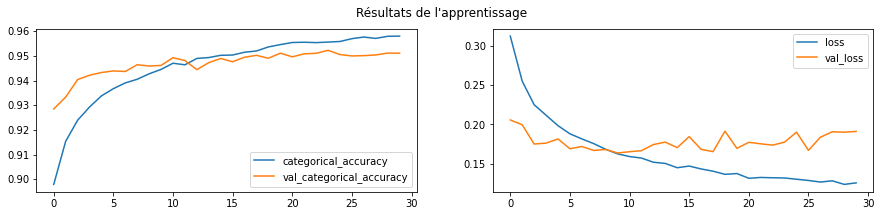

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle("Résultats de l'apprentissage")
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.legend(['categorical_accuracy', 'val_categorical_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['loss', 'val_loss'])

# Sur-entrainement

On remarque dans nos résultats que le modèle devient sur entrainé à partir d'une dizaine d'epoch. On décide donc de l'entrainer sur seulement 10 epochs, même si ses résultats semblent moins bon. 

In [27]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(28, 28)), # Résolution des images
        keras.layers.Reshape((28, 28, 1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='selu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='selu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(126, activation='relu'),
        keras.layers.Dropout(0.25),
        
        
        keras.layers.Dense(5, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])
history = model.fit(train_images, validation_data=validation_images, epochs=10)

Epoch 1/10
750/750 [==============================] - 19s 25ms/step - loss: 4.3736 - categorical_accuracy: 0.6149 - val_loss: 0.3513 - val_categorical_accuracy: 0.8898
Epoch 2/10
750/750 [==============================] - 18s 24ms/step - loss: 0.4167 - categorical_accuracy: 0.8632 - val_loss: 0.2526 - val_categorical_accuracy: 0.9169
Epoch 3/10
750/750 [==============================] - 18s 24ms/step - loss: 0.3270 - categorical_accuracy: 0.8910 - val_loss: 0.2175 - val_categorical_accuracy: 0.9257
Epoch 4/10
750/750 [==============================] - 18s 24ms/step - loss: 0.2760 - categorical_accuracy: 0.9083 - val_loss: 0.1955 - val_categorical_accuracy: 0.9327
Epoch 5/10
750/750 [==============================] - 18s 24ms/step - loss: 0.2461 - categorical_accuracy: 0.9177 - val_loss: 0.1900 - val_categorical_accuracy: 0.9361
Epoch 6/10
750/750 [==============================] - 18s 24ms/step - loss: 0.2239 - categorical_accuracy: 0.9252 - val_loss: 0.1872 - val_categorical_accuracy:

## Exemple de classification par le modèle

Pour afficher quelques exemples nous allons réutiliser les données utilisées lors de la validation. On demande au modèle de prédire la classe des images, puis on extrait une partie de ces résultats. Enfin on affiche le résultat après l'avoir convertie en texte plus explicite.

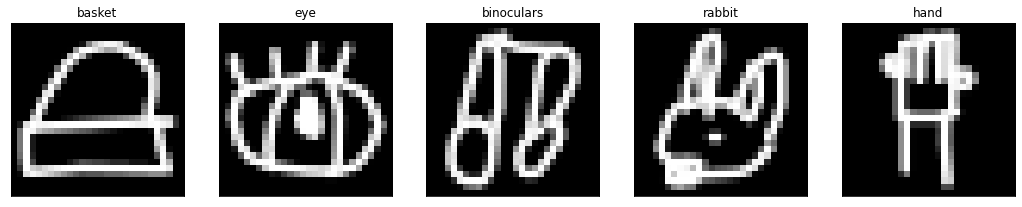

In [28]:
classes = ["basket", "eye", "binoculars", "rabbit", "hand"]

def load(filename):
    np_image = Image.open(filename)
    np_image = image.img_to_array(np_image)
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(1, 5 ,i+1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im, cmap='Greys_r')
    prediction = model.predict(load('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0]))
    prediction = np.argmax(prediction, axis = 1)[0]
    plt.title(classes[prediction])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    

## Sauvegarde du modèle

On utilise le format **HDF5** pour stocker le modèle, ce format est pratique car il permet de stocker l'architecture du modèle, les poids ainsi que les informations de compilation du modèle.

In [21]:
model.save("pouly_zangla_classifier.h5")